<a href="https://colab.research.google.com/github/majid9418/Breast-Tumor-Classification-Histopathological/blob/main/New_binary_classification_BreakHis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##IMPORT DRIVE

In [1]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "/content/drive/My Drive/projet_bcp/Deep_Learning.zip"  # Modifier avec votre chemin réel

In [4]:
import zipfile

# Définir le chemin du fichier ZIP et le dossier de destination
zip_path = "/content/drive/My Drive/projet_bcp/Deep_Learning.zip"
extract_path = "/content/extracted_data"  # Dossier où extraire les fichiers

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée !")

Extraction terminée !


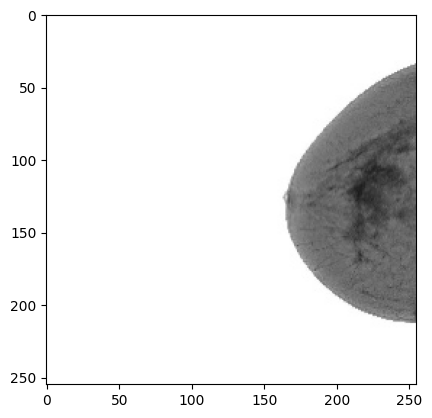

In [5]:
import cv2
import os
import matplotlib.pyplot as plt
image_path = os.path.join(extract_path, "/content/extracted_data/Deep_Learning/test/0/105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg")
img = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
img.shape

(255, 255, 3)

## Variables & bases

In [ ]:
input_shape = (224,224,3)
target_size= (224,224)

In [ ]:
#change with your folder path
folder_path = extract_path
folder_path

'/content/extracted_data'

In [ ]:
train_path = os.path.join(folder_path, "train")
valid_path = os.path.join(folder_path, "valid")
test_path = os.path.join(folder_path, "test")

## PREPROCESS THOMAS

In [ ]:
# # Define base directory
# folder_path = "/content/extracted_data/Deep_Learning"

# # Create directories for training, validation and test data
# train_path = os.path.join(folder_path, "train")
# valid_path = os.path.join(folder_path, "valid")
# test_path = os.path.join(folder_path, "test")

# # Define subdirectories for negative and positive
# negative_path = os.path.join(folder_path, '0')
# positive_path = os.path.join(folder_path, '1')

# # Create subdirectories for negative and positive in train, validation and test folders
# for category in ['0', '1']:
#     os.makedirs(os.path.join(train_path, category), exist_ok=True)
#     os.makedirs(os.path.join(valid_path, category), exist_ok=True)
#     os.makedirs(os.path.join(test_path, category), exist_ok=True)


# # General data augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     brightness_range=[0.9, 1.1],
# )


# val_datagen = ImageDataGenerator(rescale=1./255)

# # Create general data generators
# train_generator = train_datagen.flow_from_directory(
#     train_path,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

# validation_generator = val_datagen.flow_from_directory(
#     valid_path,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

# test_generator = val_datagen.flow_from_directory(
#     test_path,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

# # Calculate the number of images in each class
# class_counts = {category: len(glob.glob(os.path.join(train_path, category, '*.jpg'))) for category in ['0', '1']}
# print(class_counts)

# # Determine underrepresented class
# mean_count = np.mean(list(class_counts.values()))
# underrepresented_class = [category for category, count in class_counts.items() if count < mean_count]
# print(f"Underrepresented class: {underrepresented_class}")

Found 4744 images belonging to 2 classes.
Found 1350 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
{'0': 3138, '1': 1606}
Underrepresented class: ['1']


In [ ]:
from imgaug import augmenters as iaa
# Custom augmentation pipeline for underrepresented class
aug_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.2),
    iaa.Affine(rotate=(-45, 45)),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.AdditiveGaussianNoise(scale=(0.01*255, 0.05*255))
])

# Augment and add images for underrepresented class
for category in underrepresented_class:
    category_dir = os.path.join(train_path, category)
    images = glob.glob(os.path.join(category_dir, '*.jpg'))

    for img_path in images:
        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        for _ in range(int(mean_count / len(images))):
            aug_images = aug_pipeline(images=img_array.astype(np.uint8))
            for aug_img in aug_images:
                aug_img_path = os.path.join(category_dir, f"aug_{os.path.basename(img_path)}")
                aug_img = tf.keras.preprocessing.image.array_to_img(aug_img)
                aug_img.save(aug_img_path)


# Re-create generators after augmentation
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 6350 images belonging to 2 classes.
Found 1350 images belonging to 2 classes.
Found 672 images belonging to 2 classes.


## EfficientNetB5

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

# Define base directory
extract_path = "/content/extracted_data/Deep_Learning"  # Dossier où extraire les fichiers

#change with your folder path
folder_path = extract_path
folder_path

'/content/extracted_data/Deep_Learning'

In [8]:
print(os.listdir(folder_path))

['.DS_Store', 'train', 'test', 'valid']


In [11]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Conv2D, MaxPooling2D

# Définir le dossier contenant les images
folder_path = "/content/extracted_data/Deep_Learning"
assert os.path.exists(folder_path), "Le dossier spécifié n'existe pas."

# Définir les chemins d'entraînement, validation et test
train_path = os.path.join(folder_path, "train")
valid_path = os.path.join(folder_path, "valid")
test_path = os.path.join(folder_path, "test")

# Définir la taille des images
target_size = (224, 224)
# Définir la shape des images
input_shape = (224,224,3)

# Générateur de données avec augmentation pour l'entraînement
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.3,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     rotation_range=40,
#     width_shift_range=0.3,
#     height_shift_range=0.3,
#     brightness_range=[0.9, 1.1],
# )

# Générateur de données pour validation et test
datagen = ImageDataGenerator(rescale=1./255)

# Charger les datasets
train_dataset = datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=32,
    class_mode='binary'  # Ou 'categorical' pour plusieurs classes
)

validation_dataset = datagen.flow_from_directory(
    valid_path,
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

test_dataset = datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

# Calculer les class weights
class_labels = train_dataset.classes #/////////train_generator
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights)

# Charger le modèle pré-entraîné EfficientNetB5 sans la dernière couche
base_model = EfficientNetB5(input_shape=input_shape, include_top=False, weights='imagenet')

#/////////////////////////Model de base//////////////////////////////////
# base_model.trainable = False  # Geler les poids pour éviter de perturber l'entraînement initial

# # Définir le modèle final
# model_eff1 = Sequential([
#     base_model,  # Ajout du modèle EfficientNetB5 (sans la tête)
#     GlobalAveragePooling2D(),  # Réduction des dimensions de sortie
#     Dropout(0.8),  # Désactiver 80% des neurones pour éviter l'overfitting
#     Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))  # Couche finale binaire
# ])


# # Définir l'optimiseur
# optimizer = Adam(learning_rate=float(1e-4))  # ✅ Vérifier que learning_rate est un float
# model_eff1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

#///////////////////////////Model modifié//////////////////////////////////

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2, l2, l1

# Charger EfficientNetB5
base_model = EfficientNetB5(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # On gèle EfficientNetB5 au début

# Charger EfficientNetB5
base_model = EfficientNetB5(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # On gèle le modèle pré-entraîné au début

# Ajout de couches supplémentaires pour améliorer la performance
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Réduction des dimensions
x = BatchNormalization()(x)  # ✅ Normalisation pour stabiliser l'apprentissage
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Couche dense avec L2 Regularization
x = Dropout(0.3)(x)  # ✅ Réduit le sur-apprentissage
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Deuxième couche dense
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # ✅ Troisième couche dense
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid')(x)  # Classification binaire

# Création du modèle final
model_eff1 = Model(inputs=base_model.input, outputs=output_layer)

# ✅ Compilation du modèle avant de l'entraîner
model_eff1.compile(optimizer=Adam(learning_rate=1e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy', 'Recall'])

#//////////////////////////////////////////////////////////////////////////


# Définir les callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

def scheduler(epoch, lr):
    new_lr = max(lr * float(tf.math.exp(-0.1)), 1e-6) if epoch >= 10 else lr
    return float(new_lr)  # ✅ Convertir en float et éviter un LR trop bas

lr_callback = LearningRateScheduler(scheduler)
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

# Entraîner le modèle
history_eff1 = model_eff1.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=22,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, lr_callback, tensorboard_callback]
)


Found 4744 images belonging to 2 classes.
Found 1350 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
Class Weights: {0: 0.7558954748247291, 1: 1.4769613947696139}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 115s 407ms/step - Recall: 0.3996 - accuracy: 0.5482 - loss: 13.6053 - val_Recall: 0.7445 - val_accuracy: 0.4356 - val_loss: 12.1093 - learning_rate: 1.0000e-04
Epoch 2/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - Recall: 0.5254 - accuracy: 0.5225 - loss: 11.6859 - val_Recall: 0.9978 - val_accuracy: 0.3667 - val_loss: 10.3479 - learning_rate: 1.0000e-04
Epoch 3/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - Recall: 0.5212 - accuracy: 0.4973 - loss: 9.9625 - val_Recall: 0.7269 - val_accuracy: 0.4511 - val_loss: 8.7495 - learning_rate: 1.0000e-04
Epoch 4/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - Recall: 0.5690 - accuracy: 0.5077 - loss: 8.4032 - val_Recall: 0.5419 - val_accuracy: 0.5400 - val_loss: 7.3272 - learning_rate: 1.0000e-04
Epoch 5/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - Recall: 0.4364 - accuracy: 0.5406 - loss: 7.0300 - val_Recall: 0.6806 - val_accuracy: 0.4896 - val_loss: 6.1174 - learning_rate: 1.0000e-04
Epoch 6/22
149

Validation loss: 1.0317927598953247, Validation accuracy: 48.89%, Recall: 0.6894273161888123


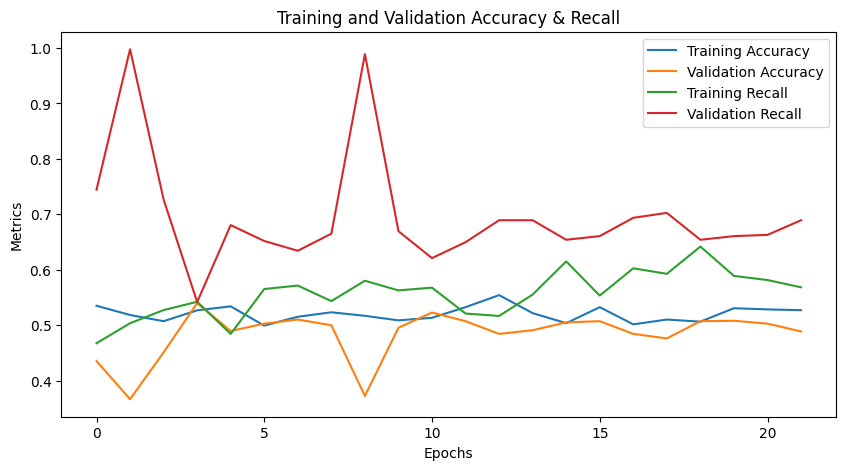

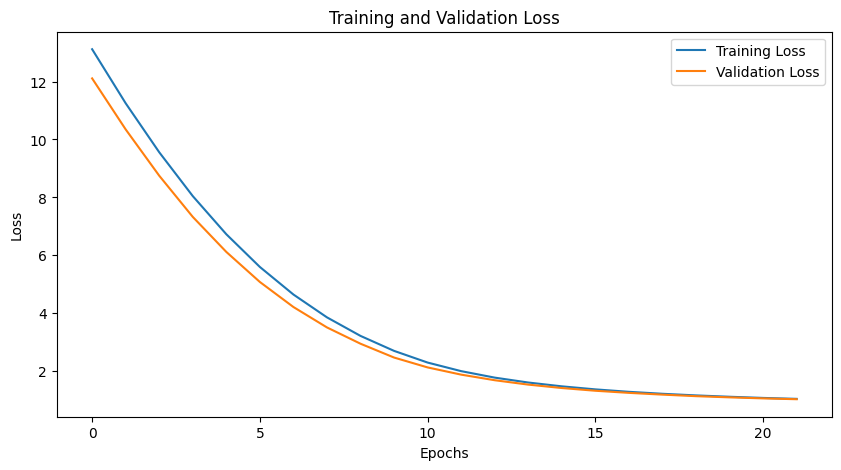

In [12]:
# Evaluate the best model
loss, accuracy, recall = model_eff1.evaluate(validation_dataset, verbose=0)
print(f'Validation loss: {loss}, Validation accuracy: {accuracy * 100:.2f}%, Recall: {recall}')

# Plot Accuracy et Recall
plt.figure(figsize=(10, 5))
plt.plot(history_eff1.history['accuracy'])
plt.plot(history_eff1.history['val_accuracy'])
plt.plot(history_eff1.history['Recall'])  # Ajout du recall
plt.plot(history_eff1.history['val_Recall'])  # Ajout du recall validation
plt.title('Training and Validation Accuracy & Recall')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Training Recall', 'Validation Recall'])
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history_eff1.history['loss'])
plt.plot(history_eff1.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

Test loss: 1.0320972204208374, Test accuracy: 50.89%, Test recall: 0.6894273161888123
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step


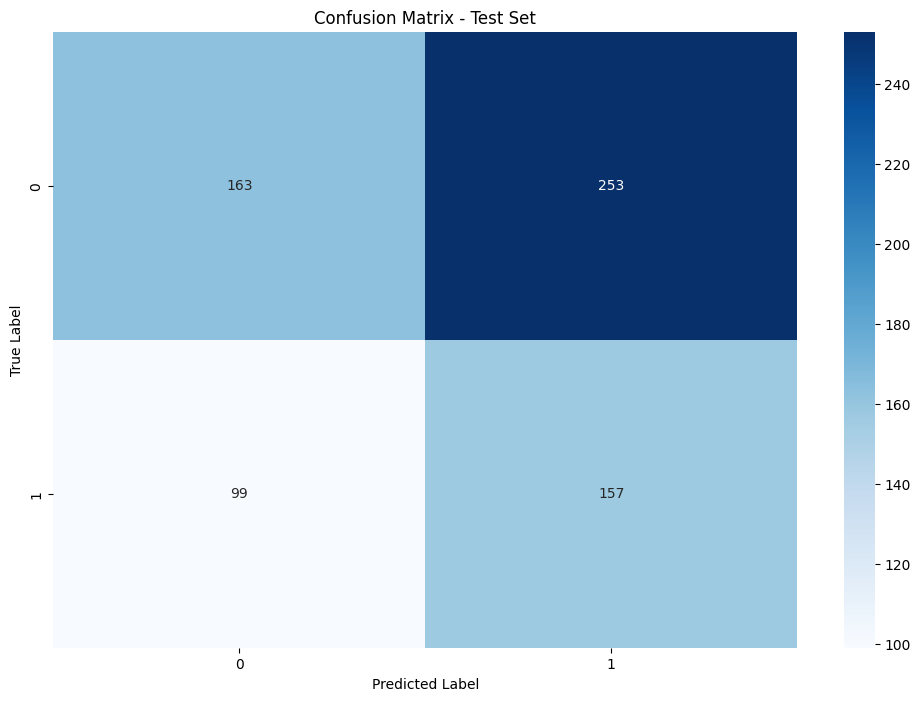

              precision    recall  f1-score   support

           0       0.62      0.39      0.48       416
           1       0.38      0.61      0.47       256

    accuracy                           0.48       672
   macro avg       0.50      0.50      0.48       672
weighted avg       0.53      0.48      0.48       672



In [13]:
# Evaluate the best model on the test set
test_loss, test_accuracy, test_recall = model_eff1.evaluate(test_dataset, verbose=0)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy * 100:.2f}%, Test recall: {recall}')

# Generate predictions on the test set
test_steps = test_dataset.samples // test_dataset.batch_size
y_pred = model_eff1.predict(test_dataset, steps=test_steps, verbose=1)
y_pred_labels = (y_pred > 0.5).astype(int)
y_true = test_dataset.classes[:len(y_pred_labels)]

# Compute the confusion matrix for the test set
conf_matrix = confusion_matrix(y_true, y_pred_labels)
class_names = ['0', '1']

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Print classification report for the test set
report = classification_report(y_true, y_pred_labels, target_names=class_names)
print(report)


Found 4744 images belonging to 2 classes.
Found 1350 images belonging to 2 classes.
Found 672 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/22


## VGG16

In [ ]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Flatten

# Définir le dossier contenant les images
folder_path = "/content/extracted_data/Deep_Learning"
assert os.path.exists(folder_path), "Le dossier spécifié n'existe pas."

# Définir les chemins d'entraînement, validation et test
train_path = os.path.join(folder_path, "train")
valid_path = os.path.join(folder_path, "valid")
test_path = os.path.join(folder_path, "test")

# Définir la taille des images
target_size = (224, 224)
# Définir la shape des images
input_shape = (224,224,3)

# Générateur de données avec augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.9, 1.1],
)

# Générateur de données pour validation et test
datagen = ImageDataGenerator(rescale=1./255)

# Charger les datasets
train_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=32,
    class_mode='binary'  # Ou 'categorical' pour plusieurs classes
)

validation_dataset = datagen.flow_from_directory(
    valid_path,
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

test_dataset = datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

# Calculer les class weights
class_labels = train_dataset.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights)

# Charger le modèle pré-entraîné EfficientNetB5 sans la dernière couche
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # On garde les poids fixes pour ne pas les modifier

# Définir le modèle final
model_vgg1 = Sequential([
    base_model,
    Flatten(),  # Remplace GlobalAveragePooling2D()
    Dense(512, activation='relu'),  # Couche intermédiaire
    Dropout(0.5),  # Moins sévère que 0.8
    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])



# Définir l'optimiseur
optimizer = Adam(learning_rate=float(1e-4))  # ✅ Vérifier que learning_rate est un float
model_vgg1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

# Définir les callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

def scheduler(epoch, lr):
    new_lr = max(lr * float(tf.math.exp(-0.1)), 1e-6) if epoch >= 10 else lr
    return float(new_lr)  # ✅ Convertir en float et éviter un LR trop bas

lr_callback = LearningRateScheduler(scheduler)
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

# Entraîner le modèle
history_vgg1 = model_vgg1.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=22,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, lr_callback, tensorboard_callback]
)




Found 4744 images belonging to 2 classes.
Found 1350 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
Class Weights: {0: 0.7558954748247291, 1: 1.4769613947696139}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 65s 418ms/step - Recall: 0.5187 - accuracy: 0.5050 - loss: 0.8274 - val_Recall: 0.0396 - val_accuracy: 0.6578 - val_loss: 0.6538 - learning_rate: 1.0000e-04
Epoch 2/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 60s 405ms/step - Recall: 0.5483 - accuracy: 0.5463 - loss: 0.7032 - val_Recall: 0.5529 - val_accuracy: 0.5644 - val_loss: 0.6877 - learning_rate: 1.0000e-04
Epoch 3/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 60s 404ms/step - Recall: 0.4710 - accuracy: 0.5555 - loss: 0.7026 - val_Recall: 0.1366 - val_accuracy: 0.6519 - val_loss: 0.6612 - learning_rate: 1.0000e-04
Epoch 4/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 61s 407ms/step - Recall: 0.4639 - accuracy: 0.5611 - loss: 0.7051 - val_Recall: 0.8282 - val_accuracy: 0.4563 - val_loss: 0.7308 - learning_rate: 1.0000e-04
Epoch 5/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 61s 413ms/step - Recall: 0.5965 - accuracy: 0.5536 - loss: 0.6933 - val_Recall: 0.6828 - val_accuracy: 0.5437 - val_loss: 0.6962 - learning_rate: 1.0000e-04
Epoch 6/22
149/

Validation loss: 0.6537615656852722, Validation accuracy: 65.78%, Recall: 0.039647575467824936


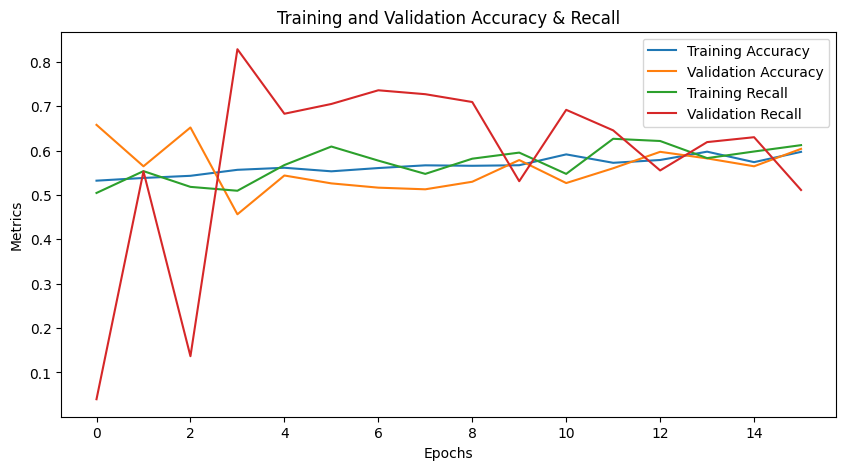

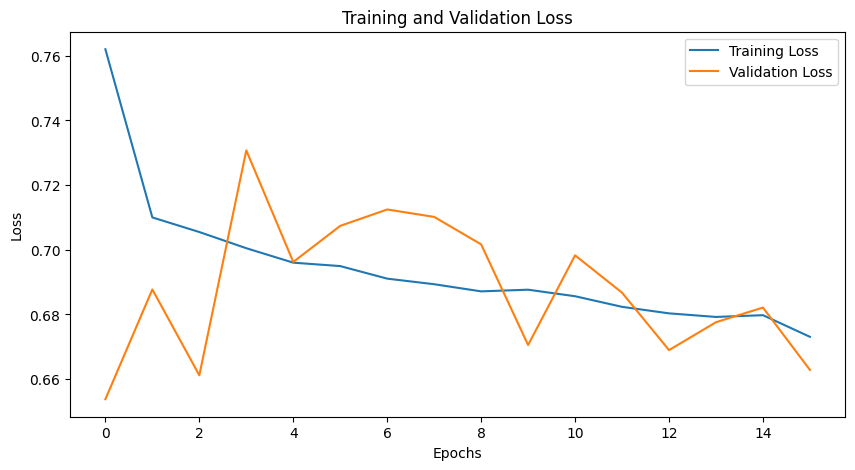

In [ ]:
# Evaluate the best model
loss, accuracy, recall = model_vgg1.evaluate(validation_dataset, verbose=0)
print(f'Validation loss: {loss}, Validation accuracy: {accuracy * 100:.2f}%, Recall: {recall}')

# Plot Accuracy et Recall
plt.figure(figsize=(10, 5))
plt.plot(history_vgg1.history['accuracy'])
plt.plot(history_vgg1.history['val_accuracy'])
plt.plot(history_vgg1.history['Recall'])  # Ajout du recall
plt.plot(history_vgg1.history['val_Recall'])  # Ajout du recall validation
plt.title('Training and Validation Accuracy & Recall')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Training Recall', 'Validation Recall'])
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history_vgg1.history['loss'])
plt.plot(history_vgg1.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

Test loss: 0.6764162182807922, Test accuracy: 61.61%, Test recall: 0.039647575467824936
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


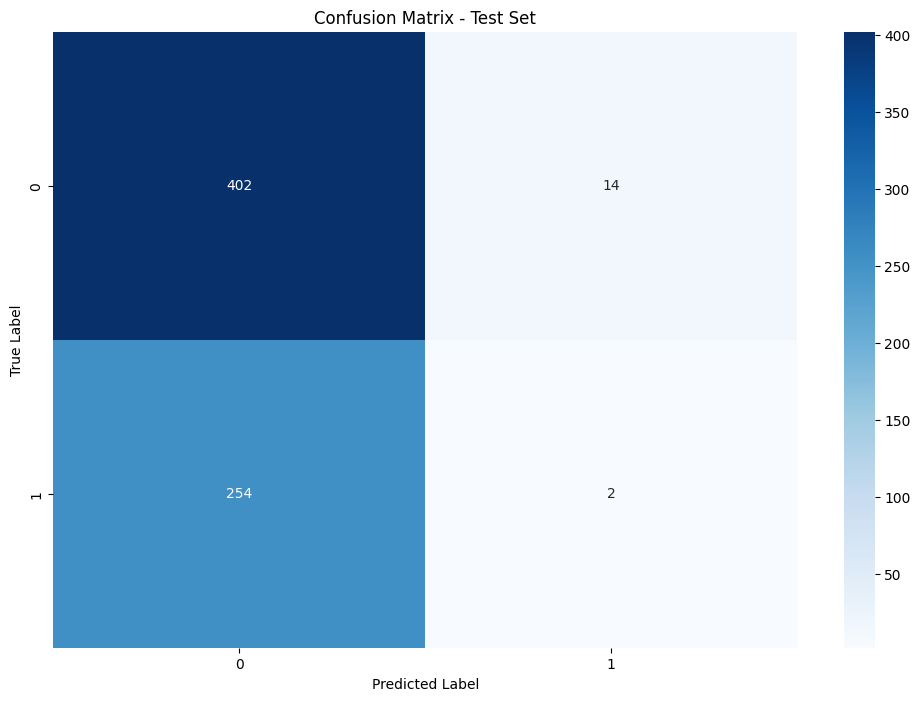

              precision    recall  f1-score   support

           0       0.61      0.97      0.75       416
           1       0.12      0.01      0.01       256

    accuracy                           0.60       672
   macro avg       0.37      0.49      0.38       672
weighted avg       0.43      0.60      0.47       672



In [ ]:
# Evaluate the best model on the test set
test_loss, test_accuracy, test_recall = model_vgg1.evaluate(test_dataset, verbose=0)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy * 100:.2f}%, Test recall: {recall}')

# Generate predictions on the test set
test_steps = test_dataset.samples // test_dataset.batch_size
y_pred = model_vgg1.predict(test_dataset, steps=test_steps, verbose=1)
y_pred_labels = (y_pred > 0.5).astype(int)
y_true = test_dataset.classes[:len(y_pred_labels)]

# Compute the confusion matrix for the test set
conf_matrix = confusion_matrix(y_true, y_pred_labels)
class_names = ['0', '1']

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Print classification report for the test set
report = classification_report(y_true, y_pred_labels, target_names=class_names)
print(report)


##RESNET50

In [ ]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Définir le dossier contenant les images
folder_path = "/content/extracted_data/Deep_Learning"
assert os.path.exists(folder_path), "Le dossier spécifié n'existe pas."

# Définir les chemins d'entraînement, validation et test
train_path = os.path.join(folder_path, "train")
valid_path = os.path.join(folder_path, "valid")
test_path = os.path.join(folder_path, "test")

# Définir la taille des images
target_size = (224, 224)
# Définir la shape des images
input_shape = (224,224,3)

# Générateur de données avec augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.9, 1.1],
)

# Générateur de données pour validation et test
datagen = ImageDataGenerator(rescale=1./255)

# Charger les datasets
train_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=32,
    class_mode='binary'  # Ou 'categorical' pour plusieurs classes
)

validation_dataset = datagen.flow_from_directory(
    valid_path,
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

test_dataset = datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

# Calculer les class weights
class_labels = train_dataset.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights)

# Charger ResNet50 sans la dernière couche
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape) #////////////////////attention input shape a voir quelle base !!!////////////////
base_model.trainable = False  # Geler les poids du modèle pour l’apprentissage transféré

# Ajouter des couches personnalisées
x = GlobalAveragePooling2D()(base_model.output)  # Remplace Flatten pour mieux généraliser
x = Dense(128, activation='relu')(x)  # Couche dense avec activation ReLU
x = Dense(64, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Créer le modèle final
model_r50 = Model(inputs=base_model.input, outputs=output_layer)

# Compiler le modèle
model_r50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])

# Définir les callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

def scheduler(epoch, lr):
    new_lr = max(lr * float(tf.math.exp(-0.1)), 1e-6) if epoch >= 10 else lr
    return float(new_lr)  # ✅ Convertir en float et éviter un LR trop bas

lr_callback = LearningRateScheduler(scheduler)
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

# Entraîner le modèle
history_r50 = model_r50.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=22,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, lr_callback, tensorboard_callback]
)




Found 4744 images belonging to 2 classes.
Found 1350 images belonging to 2 classes.
Found 672 images belonging to 2 classes.
Class Weights: {0: 0.7558954748247291, 1: 1.4769613947696139}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 87s 510ms/step - accuracy: 0.4992 - loss: 0.7005 - recall: 0.5159 - val_accuracy: 0.6637 - val_loss: 0.6813 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 63s 420ms/step - accuracy: 0.4914 - loss: 0.6921 - recall: 0.6009 - val_accuracy: 0.6637 - val_loss: 0.6824 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 63s 423ms/step - accuracy: 0.5277 - loss: 0.6949 - recall: 0.3816 - val_accuracy: 0.3363 - val_loss: 0.7138 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/22
149/149 ━━━━━━━━━━━━━━━━━━━━ 63s 420ms/step - accuracy: 0.5010 - loss: 0.6940 - recall: 0.4490 - val_accuracy: 0.3363 - val_loss: 0.7363 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/22
139/149 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - accuracy: 0.4187 - loss: 0.7024 - recall: 0.7160

KeyboardInterrupt: 

Validation loss: 0.6848514080047607, Validation accuracy: 56.74%, Recall: 0.5814977884292603


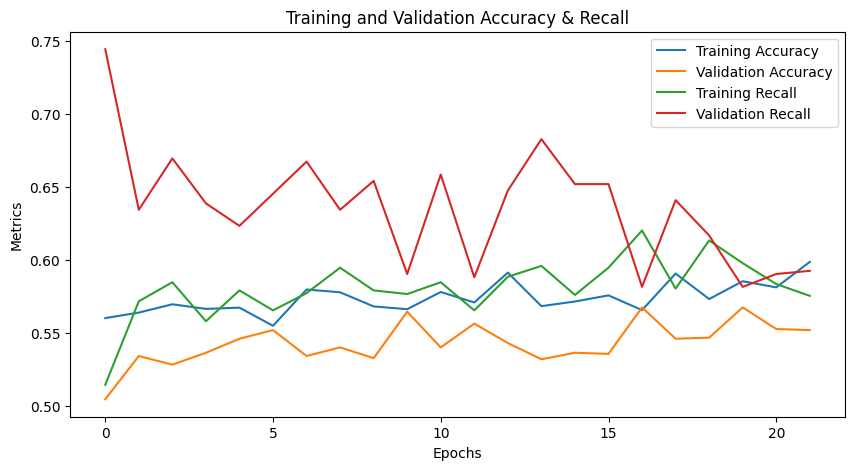

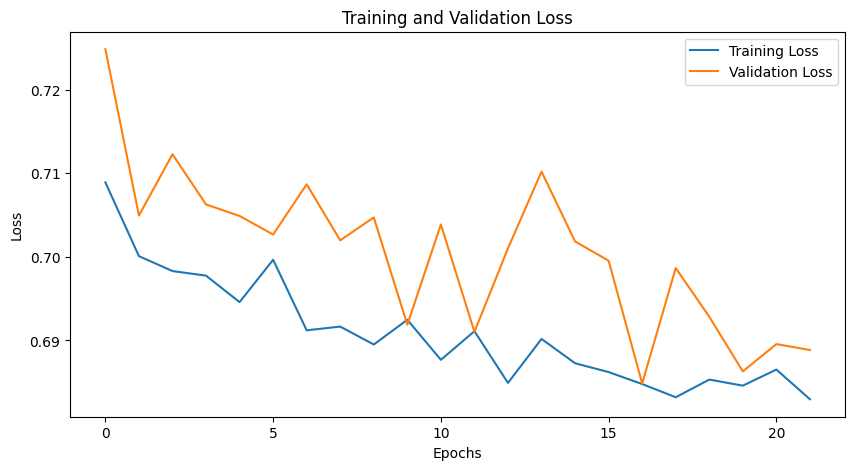

In [ ]:
# Evaluate the best model
loss, accuracy, recall = model.evaluate(validation_dataset, verbose=0)
print(f'Validation loss: {loss}, Validation accuracy: {accuracy * 100:.2f}%, Recall: {recall}')

# Plot Accuracy et Recall
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['Recall'])  # Ajout du recall
plt.plot(history.history['val_Recall'])  # Ajout du recall validation
plt.title('Training and Validation Accuracy & Recall')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Training Recall', 'Validation Recall'])
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test loss: 0.8891249895095825, Test accuracy: 38.10%, Test recall: 0.5814977884292603
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step


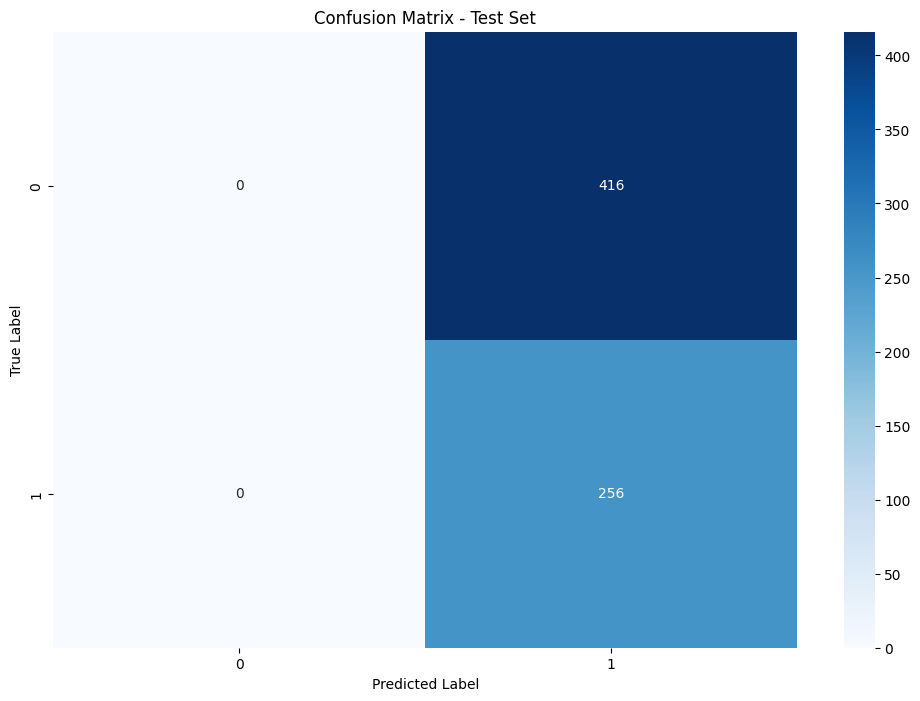

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       416
           1       0.38      1.00      0.55       256

    accuracy                           0.38       672
   macro avg       0.19      0.50      0.28       672
weighted avg       0.15      0.38      0.21       672



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Evaluate the best model on the test set
test_loss, test_accuracy, test_recall = model_r50.evaluate(test_dataset, verbose=0)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy * 100:.2f}%, Test recall: {recall}')

# Generate predictions on the test set
test_steps = test_dataset.samples // test_dataset.batch_size
y_pred = model_r50.predict(test_dataset, steps=test_steps, verbose=1)
y_pred_labels = (y_pred > 0.5).astype(int)
y_true = test_dataset.classes[:len(y_pred_labels)]

# Compute the confusion matrix for the test set
conf_matrix = confusion_matrix(y_true, y_pred_labels)
class_names = ['0', '1']

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Print classification report for the test set
report = classification_report(y_true, y_pred_labels, target_names=class_names)
print(report)


#PREDICTION

In [ ]:
# make a prediction for a new image.


def predictImage(url, model):
    '''Takes an image and a model
    '''
    img = load_img(url, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array.reshape((-1, 224, 224, 3))
    res = model.predict(img_array)[0][0]

    if res < 0.5:
        diagnostic = "Négatif"
        prob = 1 - res
    else:
        diagnostic = "Positif"
        prob = res

    plt.imshow(array_to_img(img_array[0]))
    plt.axis("off")
    plt.title(f"{diagnostic} ({prob:.2%})")


    return  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


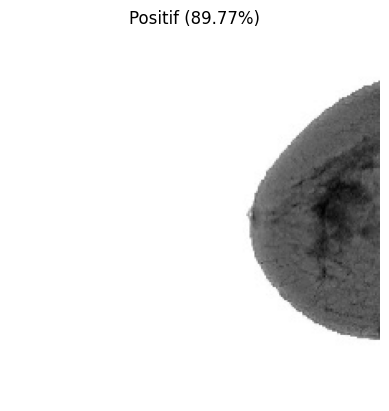

In [ ]:
predictImage("/content/extracted_data/Deep_Learning/test/0/105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg", model)